In [47]:
# loads path to your input files : base_processed, base_raw, base_models...
%run init_notebook.py

In [48]:
# Optional : list the available files to chose one for the next cell
import os

csv_files = [file for file in os.listdir(base_raw) if file.endswith('.csv')]
print("\nAvailable files in the raw folder:\n")
for file in csv_files:
    print("* "+file)



Available files in the raw folder:

* dummy_fin_data_v02.csv
* status_20250331.csv


In [49]:
# enter the file name (no extension) you want to work with
my_data_file = 'dummy_fin_data_v02'  # default example
my_data_file = 'status_20250331'

In [50]:
!pip install ipywidgets 

In [51]:
# for notebook display mode only (not in VScode)
"""
import os
import ipywidgets as widgets
from IPython.display import display

# Define the directory to list files from
file_path = base_raw


# Create a dropdown widget to list files
def update_files(change):
    selected_file.value = change['new']

files = os.listdir(file_path)
file_dropdown = widgets.Dropdown(options=files, description='Files:')
selected_file = widgets.Text(value='', description='Selected File:')

file_dropdown.observe(update_files, names='value')

# Display the dropdown and selected file
display(file_dropdown, selected_file)
"""

"\nimport os\nimport ipywidgets as widgets\nfrom IPython.display import display\n\n# Define the directory to list files from\nfile_path = base_raw\n\n\n# Create a dropdown widget to list files\ndef update_files(change):\n    selected_file.value = change['new']\n\nfiles = os.listdir(file_path)\nfile_dropdown = widgets.Dropdown(options=files, description='Files:')\nselected_file = widgets.Text(value='', description='Selected File:')\n\nfile_dropdown.observe(update_files, names='value')\n\n# Display the dropdown and selected file\ndisplay(file_dropdown, selected_file)\n"

In [52]:
import pandas as pd
# Read the CSV file into a new DataFrame
df = pd.read_csv(base_raw + my_data_file + '.csv')

# in case needed
# print(df)

In [53]:
import matplotlib.pyplot as plt
import itertools

def create_distrib(df, variable_, file_name):
    """
    Create and save a distribution chart (pie chart) for a given column of a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
        variable_ (str): The column of the DataFrame to analyze (e.g., 'geography').
        file_name (str): The base name of the file to use for saving the plot.

    The plot is saved as:
        base_images + file_name + '_' + variable_ + '_distrib.png'

    Returns:
        None
    """
    # Replace missing values in the selected variable with 'not specified'
    df[variable_] = df[variable_].fillna('not specified')

    # Group the data by the selected variable and sum the 'amount' column, sorting by descending values
    grouped_data = df.groupby(variable_)['amount'].sum().sort_values(ascending=False)

    # Define pastel colors
    pastel_colors = [
        '#B3D9FF', '#FFB3BA', '#FFDFBA', '#FFFFBA', '#BAFFC9', '#BAE1FF', 
        '#F3E5AB', '#AFE1AF', '#AFCBFF', '#FFCCE4', '#FFE1A8', '#FFFFD1', 
        '#C2F0C2', '#C4E4FF', '#FFADC4', '#FFDDCC', '#FFF9CC', '#B6F3B6', '#FFC8DD'
    ]

    # Ensure the number of colors matches the number of slices
    adjusted_colors = list(itertools.islice(itertools.cycle(pastel_colors), len(grouped_data)))

    # Define a function to display labels only for larger slices
    def autopct_format(pct):
        return f'{pct:.1f}%' if pct > 4 else ''  # Only show if the slice is > 4%

    # Define a function to filter labels based on percentage size
    def filter_labels(data, threshold=4):
        total = data.sum()
        return [label if (value / total * 100) > threshold else '' for label, value in zip(data.index, data.values)]

    # Calculate filtered labels
    filtered_labels = filter_labels(grouped_data, threshold=4)

    # Create the pie chart
    plt.figure(figsize=(5, 5))
    plt.pie(
        grouped_data.values,  # Use sorted values for pie slices
        labels=filtered_labels,  # Use filtered labels
        startangle=90,  # Start angle for pie chart
        colors=adjusted_colors,  # Use adjusted colors matching sorted data
        autopct=autopct_format,  # Display percentages based on threshold
        shadow=True,  # Add shadow for visual effect
        wedgeprops=dict(linewidth=0.2, edgecolor='grey')  # Pie slice border style
    )

    # Create legend handles with sorted labels and corresponding colors
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color=color, label=label, linestyle='')
        for label, color in zip(grouped_data.index, adjusted_colors)
    ]

    # Add the legend
    plt.legend(
        handles=legend_handles,
        loc="best",  # Automatically position the legend
        title=variable_.capitalize(),  # Title for the legend
        fontsize=6,  # Font size for compact display
        ncol=1  # Number of columns for the legend
    )

    # Add a title
    plt.title(f'Distribution of {variable_}', fontsize=14, y=1.1)

    # Save the plot as a PNG file with high resolution
    save_path = base_images + file_name + '_' + variable_ + '_distrib.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()


In [54]:
import numpy as np

# Replace NaN values in 'geography' and 'type' with 'not specified'
df['geography'] = df['geography'].fillna('not specified')
df['type'] = df['type'].fillna('not specified')

# Get the unique types
types = df['type'].unique()

# Group by 'geography' and calculate the sum of 'amount' for each 'type'
grouped = df.groupby(['geography', 'type'])['amount'].sum().unstack(fill_value=0)

# Convert the grouped data into a NumPy array of tuples
result_array = np.array([tuple(row) for row in grouped.values])

# Display the result
# print(result_array)

In [55]:
# for developper info only
"""
# Display the grouped DataFrame
print(grouped)

# Display the row index (geography values)
print("Row index (geography):", grouped.index.tolist())

# Display the column names (type values)
print("Column names (types):", grouped.columns.tolist())
"""

'\n# Display the grouped DataFrame\nprint(grouped)\n\n# Display the row index (geography values)\nprint("Row index (geography):", grouped.index.tolist())\n\n# Display the column names (type values)\nprint("Column names (types):", grouped.columns.tolist())\n'

In [56]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools

def create_donuts(df, variable_inner, variable_outer, file_name):
    """
    Create a nested (donut) chart showing the distribution of `variable_outer` by `variable_inner`.
    
    The values are always taken from the 'amount' column.
    Fixed pastel color palettes are used for both rings.
    Both the inner and outer slices are sorted in descending order (from biggest to smallest amounts).
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        variable_inner (str): The column for the inner ring (e.g., 'geography').
        variable_outer (str): The column for the outer ring (e.g., 'type').
        file_path (str): Full path (with filename and extension) to save the resulting image.
    
    Returns:
        None
    """

    file_path = base_images + file_name + '_' + variable_outer + '_by_' + variable_inner + '.png'

    # --- Prepare and sort the data ---
    # Replace missing values with 'not specified'
    df[variable_inner] = df[variable_inner].fillna("not specified")
    df[variable_outer] = df[variable_outer].fillna("not specified")
    
    # Group by the inner variable and sum the 'amount'
    grouped_inner = df.groupby(variable_inner)['amount'].sum()
    # Sort inner groups in descending order (largest amount first)
    sorted_inner = grouped_inner.sort_values(ascending=False)
    
    # Group by both inner and outer variables and sum the 'amount'
    grouped_outer = df.groupby([variable_inner, variable_outer])['amount'].sum()
    
    # For color consistency across the outer slices, get overall outer totals (sorted descending)
    outer_total = df.groupby(variable_outer)['amount'].sum().sort_values(ascending=False)
    
    # --- Define fixed color palettes ---
    # Fixed pastel colors for inner ring (donut)
    pastel_colors_inner = ['#FFB3BA', '#FFDFBA', '#FFFFBA', '#BAFFC9', '#BAE1FF']
    # Fixed pastel colors for outer ring
    outer_colors_palette = ['#B3E5FC', '#C8E6C9', '#FFCCBC', '#D1C4E9', '#F8BBD0', '#F0F4C3']
    
    # Create a type-to-color mapping for the outer variable (consistent across all inner groups)
    type_color_mapping = {
        label: color for label, color in zip(outer_total.index, itertools.cycle(outer_colors_palette))
    }
    
    # Create list of inner colors (cycle the inner palette if needed)
    inner_colors_list = list(itertools.islice(itertools.cycle(pastel_colors_inner), len(sorted_inner)))
    
    # --- Create the figure and plot the inner donut ---
    plt.figure(figsize=(8, 8))
    
    # Plot inner pie (donut) chart using the sorted inner data
    plt.pie(
        sorted_inner.values,                # Use sorted amounts (largest first)
        labels=sorted_inner.index,          # Corresponding inner labels
        startangle=90,
        colors=inner_colors_list,           # Colors adjusted for the number of slices
        radius=0.8,                         # Inner donut radius
        wedgeprops=dict(width=0.5, edgecolor='w'),
        pctdistance=1.25,
        labeldistance=0.7
    )
    
    # --- Prepare and plot the outer donut chart ---
    outer_sizes = []
    outer_labels = []
    outer_colors_list = []
    
    # Process each inner category in sorted order
    for inner_label in sorted_inner.index:
        # Get outer sub-data for this inner category and sort in descending order
        try:
            outer_dist = grouped_outer.loc[inner_label].sort_values(ascending=False)
        except KeyError:
            continue  # In case there is no subgroup for this inner label
        
        # Append each outer slice info to our lists
        for outer_label, value in outer_dist.items():
            outer_sizes.append(value)
            outer_labels.append(outer_label)
            # Retrieve the consistent color from our mapping
            outer_colors_list.append(type_color_mapping[outer_label])
    
    # Plot the outer donut pie
    plt.pie(
        outer_sizes,
        labels=outer_labels,
        startangle=90,
        colors=outer_colors_list,
        radius=1.2,                        # Outer donut radius (wider than inner)
        wedgeprops=dict(width=0.4, edgecolor='w'),
        pctdistance=1.25,
        labeldistance=0.9
    )
    
    # --- Create legends ---
    # Legend for the inner donut (variable_inner)
    legend_inner = plt.legend(
        handles=[
            plt.Line2D([0], [0], marker='o', color=color, label=label, linestyle='')
            for label, color in zip(sorted_inner.index, inner_colors_list)
        ],
        loc="upper left",
        fontsize=6,
        title=variable_inner.capitalize()
    )
    
    # Legend for the outer donut (variable_outer)
    # Use the overall sorted outer totals for consistent ordering
    legend_outer = plt.legend(
        handles=[
            mpatches.Patch(color=type_color_mapping[label], label=label)
            for label in outer_total.index
        ],
        loc="upper right",
        fontsize=6,
        title=variable_outer.capitalize()
    )
    
    # Because only one legend can be active at a time, add the inner legend back
    plt.gca().add_artist(legend_inner)
    
    # --- Add title and save / show the plot ---
    plt.title(f'{variable_outer.capitalize()} by {variable_inner} ', fontsize=14, y=1.1)
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.show()


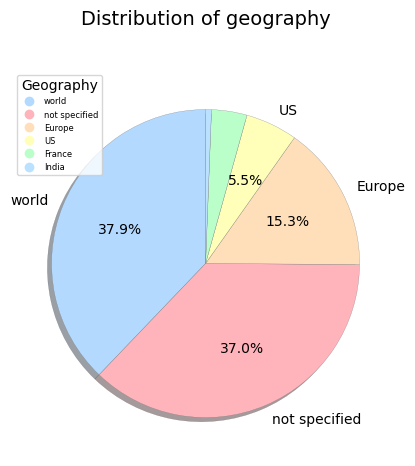

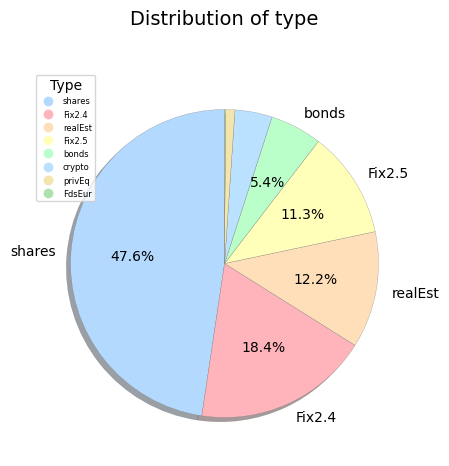

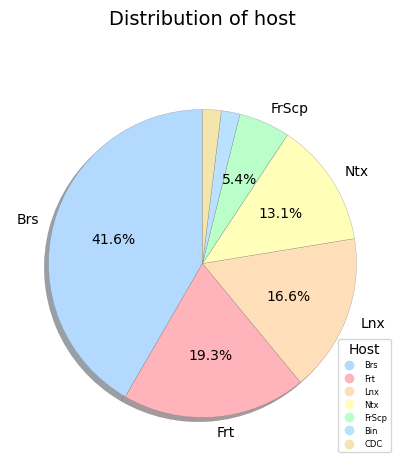

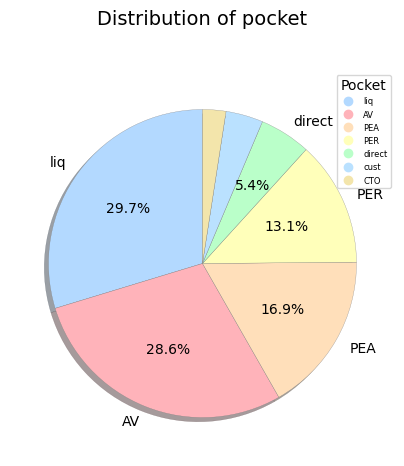

In [57]:
# List of variable names
variables = ['geography', 'type', 'host', 'pocket']

# Loop through the variables and call create_distrib
for variable in variables:
    create_distrib(
        df=df,
        variable_=variable,
        file_name=my_data_file
    )

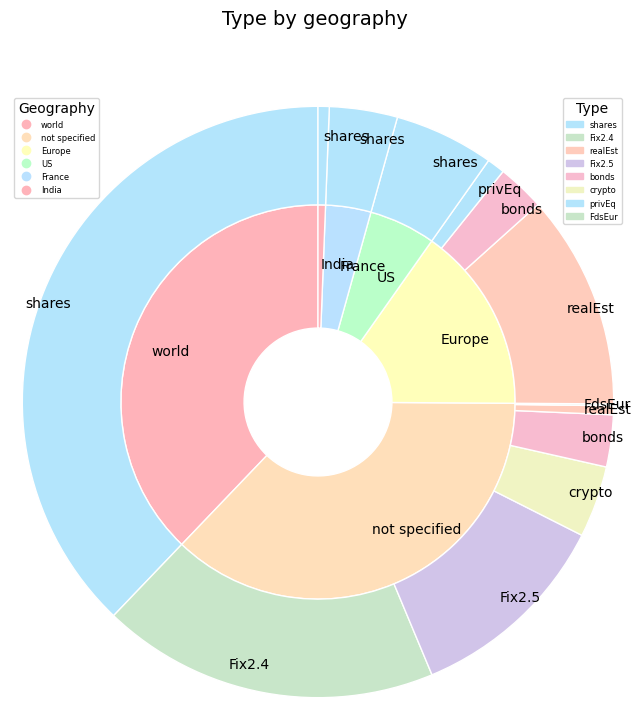

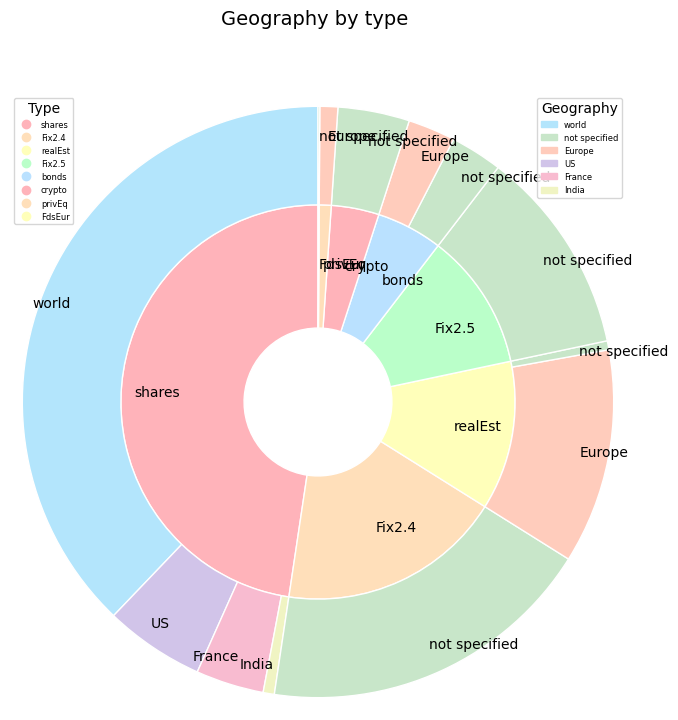

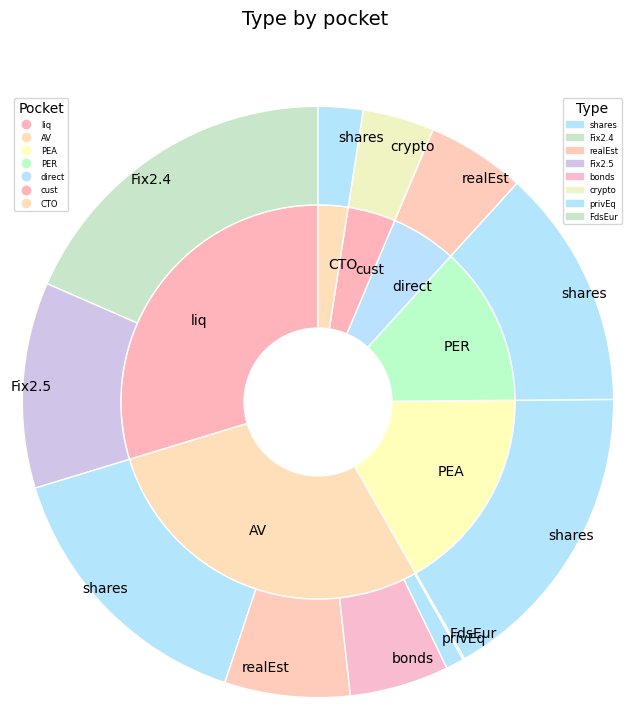

In [58]:
# List of variable combinations
variable_combinations = [
    ('geography', 'type'),
    ('type', 'geography'),
    ('pocket', 'type')
]

# Loop through the combinations and call create_donuts
for inner, outer in variable_combinations:
    create_donuts(
        df=df,
        variable_inner=inner,
        variable_outer=outer,
        file_name=my_data_file
    )